In [ ]:
# package imports
import ee
import numpy as np
import geemap
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import os
from pyproj import Transformer, Proj, transform

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

## S1 download

S2 to S1 mapping

In [2]:
start_date = '2019-07-01'
end_date = '2019-07-10'
tile_id = '36UYA'

# Load the Sentinel-2 image collection and filter it
sentinel2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.eq('MGRS_TILE', tile_id))

# Get the first Sentinel-2 image and its footprint
image_list = sentinel2.toList(sentinel2.size())
first_s2_image = ee.Image(image_list.get(0))
footprint_polygon = first_s2_image.geometry()
footprint_polygon_buffered = footprint_polygon.buffer(1000)

start_date_s1 = '2019-07-01'

# Load the Sentinel-1 image collection for the same range
sentinel1 = ee.ImageCollection('COPERNICUS/S1_GRD') \
    .filter(ee.Filter.eq("instrumentMode", "IW")) \
    .filterDate(start_date_s1, end_date) \
    .filterBounds(footprint_polygon_buffered)  \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV')) \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VH')) \
    .filter(ee.Filter.eq("orbitProperties_pass", "DESCENDING")) \
    .select(['VV', 'VH']) \
    .sort('system:time_start', False)  # Sort images in descending order by date

# Mosaic the images to create one image covering the entire area
print("Number of Sentinel-1 images: ", sentinel1.size().getInfo())

# Clip the mosaic to the exact Sentinel-2 footprint
s1_mosaic = sentinel1.mosaic().clip(footprint_polygon)

# Example to process and visualize
Map = geemap.Map()
Map.addLayer(first_s2_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 Image')
Map.addLayer(s1_mosaic, {'bands': ['VH'], 'min': -50, 'max': 0}, 'Mosaic Sentinel-1 Image')
Map.centerObject(footprint_polygon, zoom=10)
Map

Number of Sentinel-1 images:  4


Map(center=[50.00407237826777, 36.55656098911121], controls=(WidgetControl(options=['position', 'transparent_b…

Adjust the mapping to the new S1

In [ ]:
# Get the first Sentinel-2 image's CRS and transform
first_s2_image = sentinel2.first()
s2_info = first_s2_image.getInfo()
s2_crs = s2_info['bands'][1]['crs']  # CRS of the first band
s2_transform = s2_info['bands'][1]['crs_transform']  # Transform of the first band

s1_aligned_mosaic = s1_mosaic.reproject(crs=s2_crs, crsTransform=s2_transform)

Map = geemap.Map()
#Map.addLayer(first_s2_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}, 'Sentinel-2 Image')
Map.addLayer(s1_aligned_mosaic, {'bands': ['VH'], 'min': -25, 'max': 0}, 'Mosaic Sentinel-1 Image')
Map.centerObject(footprint_polygon, zoom=10)
Map

Download

In [ ]:
taks = ee.batch.Export.image.toDrive(**{
    'image': s1_aligned_mosaic,
    'description': f'S1_Image_{tile_id}_{start_date}',
    'folder': 'Sentinel-1',
    'fileNamePrefix': f'S1_Image_{tile_id}_{start_date}',
    'scale': 10,
    'region': first_s2_image.geometry().bounds().getInfo()['coordinates'],
    'crs': s2_crs,
    'fileFormat': 'GeoTIFF',
    'maxPixels': 1e12
})

taks.start()

## S1 preprocessing

Crop image to the region of interest

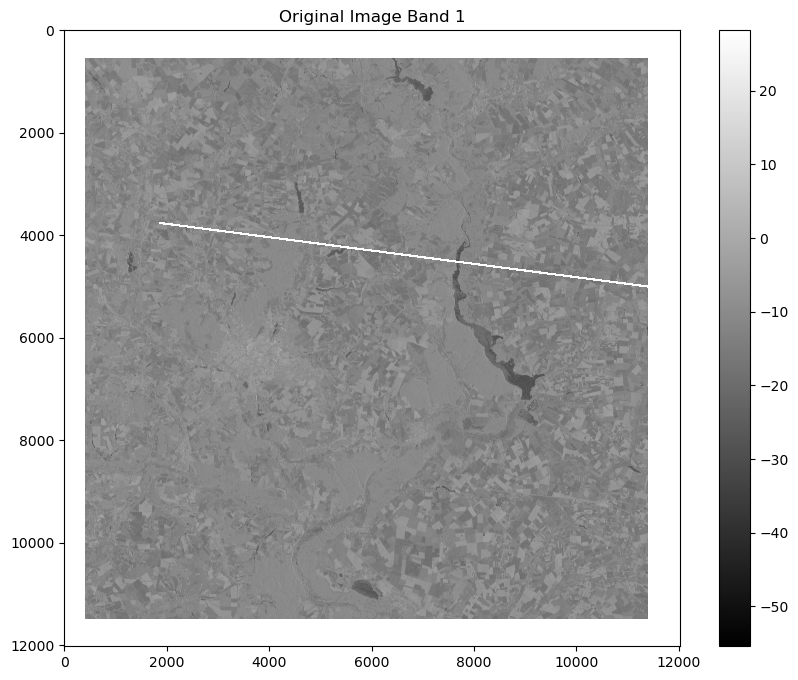

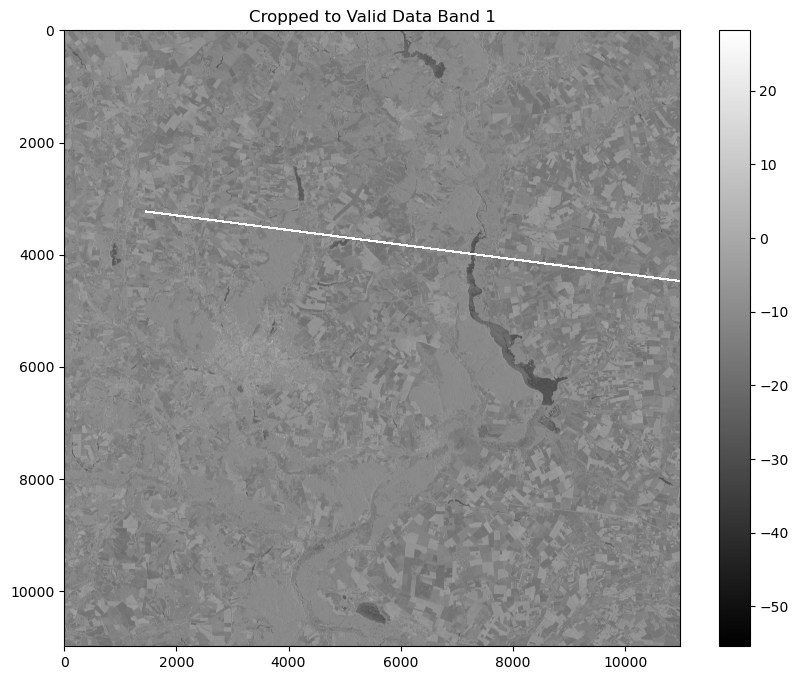

In [40]:

def find_valid_bounds(images, nodata_value=np.nan):
    """Find bounds within images that do not contain only nodata values for any band."""
    valid_rows = np.zeros(images.shape[1], dtype=bool)
    valid_cols = np.zeros(images.shape[2], dtype=bool)
    
    for image in images:
        if np.isnan(nodata_value):
            band_valid_rows = ~np.isnan(image).all(axis=1)
            band_valid_cols = ~np.isnan(image).all(axis=0)
        else:
            band_valid_rows = (image != nodata_value).any(axis=1)
            band_valid_cols = (image != nodata_value).any(axis=0)
        
        valid_rows = valid_rows | band_valid_rows
        valid_cols = valid_cols | band_valid_cols
    
    ymin, ymax = np.where(valid_rows)[0][[0, -1]]
    xmin, xmax = np.where(valid_cols)[0][[0, -1]]

    return xmin, xmax, ymin, ymax

# Open the image
base_path_s1 = ''
image_s1 = "S1_Image_36UYA_2019-07-01.tif"

with rasterio.open(os.path.join(base_path_s1, image_s1)) as src:
    # Read all bands; assuming two bands for this example
    img_s1 = src.read([1, 2])  # Adjust the index depending on your bands
    img_s1_crs = src.crs
    img_s1_transform = src.transform

    plt.figure(figsize=(10, 8))
    plt.imshow(img_s1[0], cmap='gray')  # Display the first band
    plt.colorbar()
    plt.title('Original Image Band 1')
    plt.show()

    # Assuming the NA values are NaNs or another specific value
    nodata_value = src.nodata if src.nodata is not None else np.nan
    
    # Find the bounds of the valid data for all bands
    xmin, xmax, ymin, ymax = find_valid_bounds(img_s1, nodata_value=nodata_value)
    
    # Crop all bands to these bounds
    img_s1_cropped = img_s1[:, ymin:ymax+1, xmin:xmax+1]

    # Plot the cropped first band
    plt.figure(figsize=(10, 8))
    plt.imshow(img_s1_cropped[0], cmap='gray')
    plt.colorbar()
    plt.title('Cropped to Valid Data Band 1')
    plt.show()


Fill NA values with the median of the image

In [ ]:
img_s1_aligned = np.stack((img_s1_cropped[0][0:10980, 1:10981], img_s1_cropped[0][0:10980, 1:10981]))

# Fill NaN values
median_value = np.nanmedian(img_s1_aligned)

print(np.isnan(img_s1_aligned).sum())
# Replace NaN values with the median
img_s1_aligned[np.isnan(img_s1_aligned)] = median_value

# Print the updated array to check (optional)
print(img_s1_aligned)

S2 vs S1 visual comparison

In [ ]:
base_path_s2 = ''
image_s2 = "S2A_Image_36UYA_20190701.tif"
with rasterio.open(os.path.join(base_path_s2, image_s2)) as file:

    # createa window
    window = rasterio.windows.Window(5000, 5000, 512, 512)

    # read the image
    img_s2 = file.read([1,2,3], window=window)
    print(img_s2.shape)

img_s1_window = img_s1_aligned[1][5000:5512, 5000:5512]


max_s2 = np.percentile(img_s2, 98)
min_s2 = np.percentile(img_s2, 2)
img_s2 = (img_s2 - min_s2) / (max_s2 - min_s2)
img_s2 = np.clip(img_s2, 0, 1)

max_s1 = np.percentile(img_s1_window, 98)
min_s1 = np.percentile(img_s1_window, 2)
img_s1_window = (img_s1_window - min_s1) / (max_s1 - min_s1)
img_s1_window = np.clip(img_s1_window, 0, 1)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].imshow(img_s1_window, cmap='gray')
ax[0].set_title('Sentinel-1 Image')

ax[1].imshow(img_s2.transpose(1, 2, 0))
ax[1].set_title('Sentinel-2 Image')

plt.show()

Save processed S1 image

In [46]:
save_path = ''
output_path = os.path.join(save_path, 'S1_Image_36UYA_20190701.tif')

if not os.path.exists(save_path):
    os.makedirs(save_path)
    print(f"Directory created: {save_path}")
try:
    with rasterio.open(
        output_path, 'w',
        driver='GTiff',
        height=img_s1_aligned.shape[1],
        width=img_s1_aligned.shape[2],
        count=img_s1_aligned.shape[0],
        dtype=str(img_s1_aligned.dtype),
        crs=img_s1_crs,
        transform=img_s1_transform
    ) as dst:
        for i in range(img_s1_aligned.shape[0]):
            dst.write(img_s1_aligned[i], i+1)
    print("File saved successfully.")
except Exception as e:
    print(f"An error occurred: {e}")

File saved successfully.
